In [1]:

from mmhuman3d.apis import init_model, inference_image_based_model
from mmhuman3d.core.conventions.keypoints_mapping import convert_kps
from mmhuman3d.core.visualization import visualize_smpl_hmr
from mmhuman3d.data.data_structures.human_data import HumanData
from mmhuman3d.utils.demo_utils import xywh2xyxy
from mmhuman3d.utils.transforms import rotmat_to_aa

import mmcv 
import numpy as np

# image file path or loaded image
frame = mmcv.imread(
    'demo/resources/S1_Directions_1.54138969_000001.jpg')

# If you want to do inference on your data, you should provide the `bbox`.
# If your can't provide the `bbox`, please refer to `demo/estimate_smpl_video.py`, 
# which uses `mmdet` or `mmtrack` to detect the `bbox`.
# Note: the format of bbox should be `xyxy`
bbox_xywh = np.array([
                264.9376922607422,
                263.9518524169922,
                403.4372680664062,
                403.4372680664062,
                1 # confidence
            ])
bbox_xyxy = xywh2xyxy(bbox_xywh)
person_results = [{'bbox':bbox_xyxy}]
# Specify the path to model config and checkpoint file
config_file = 'configs/spin/resnet50_spin_pw3d.py'
checkpoint_file = 'data/checkpoints/mmhuman3d/spin/epoch_1.pth'

# Build the model from the config file and the checkpoint file
# config_file: config file path or the config object.
# checkpoint_file: checkpoint path
mesh_model, _ = init_model(
    config_file,  
    checkpoint_file,
    device='cuda:0')

# test a single image, with a list of bboxes.
# mesh_model (nn.Module): the loaded mesh model
# frame (Union[str, np.ndarray]): image file path or loaded image.
# person_results (List(dict)): the item in the dict may contain 
# 'bbox' and/or 'track_id'. 
mesh_results = inference_image_based_model(
    mesh_model,
    frame,
    person_results,
    format='xyxy')

# mesh_results (list[dict]): Each item in the list is a dictionary,
# containing the `bbox`: (left, top, right, bottom, [score]),
# `smpl_pose`, `smpl_beta`, `vertices`, `keypoints_3d`, and `camera`.
verts = mesh_results[0]['vertices'][None]
smpl_pose = rotmat_to_aa(mesh_results[0]['smpl_pose'])[None]
betas = mesh_results[0]['smpl_beta'][None]
pred_cam = mesh_results[0]['camera'][None]
kp3d = mesh_results[0]['keypoints_3d'][None]

embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink
Use load_from_local loader


Overwriting data/vis_result and its files.


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


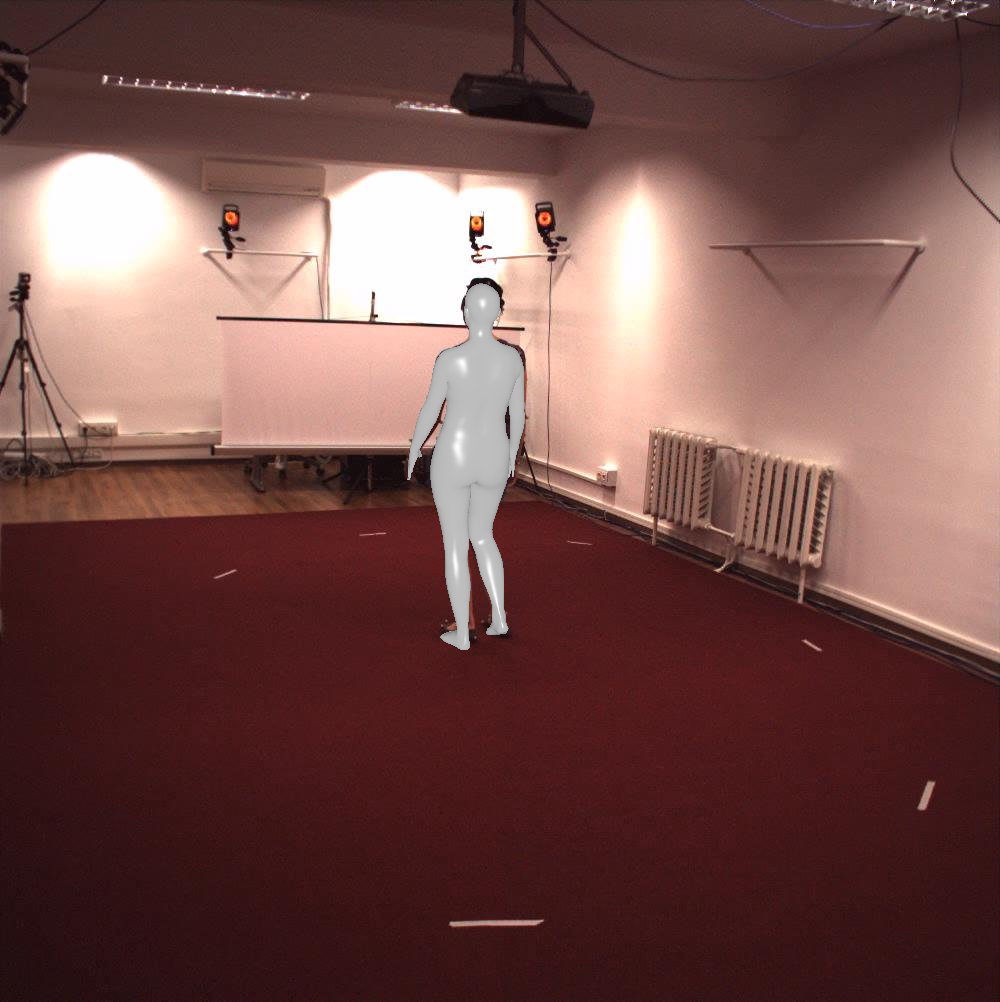

In [3]:
# A better illustration of the visualization can be found in `docs/visualize_smpl.md`

from IPython.display import Image, display
import os.path as osp

show_path = 'data/vis_result'
visualize_smpl_hmr(
    pred_cam,
    bbox_xyxy,                
    verts=verts,
    model_path='data/body_models',
    model_type='smpl',
    output_path=show_path,
    image_array=frame,
    resolution = frame.shape[:2],
    overwrite=True
)

file_name = osp.join(show_path,'000000.png')
display(Image(file_name,width=500,height=500))

In [4]:

# A better illustration of the HumanData can be found in `docs/human_data.md`

smpl = {}
smpl['body_pose'] = smpl_pose[1:, :]
smpl['global_orient'] = smpl_pose[0, :]
smpl['betas'] = betas

conf = np.ones(kp3d.shape[:-1])[..., None]
kp3d = np.concatenate([kp3d, conf], axis=-1)
keypoints3d_, keypoints3d_mask = \
    convert_kps(kp3d, 'h36m', 'human_data')

human_data = HumanData()
human_data['bbox_xywh'] = bbox_xywh[None]
human_data['keypoints3d'] = keypoints3d_
human_data['keypoints3d_mask'] = keypoints3d_mask
human_data['smpl'] = smpl
human_data.compress_keypoints_by_mask()

output = 'data/vis_result/results.npz'
human_data.dump(output)